In [1]:
import os
from itertools import product
import json

import numpy as np
import matplotlib.pyplot as plt

from grid_search import K_CANDIDATES
from visualization.utils import gradient_line

In [2]:
GROUP_LABELS = {
    1: 'Mainstream',
    2: 'Diverse',
    3: 'Niche',
}

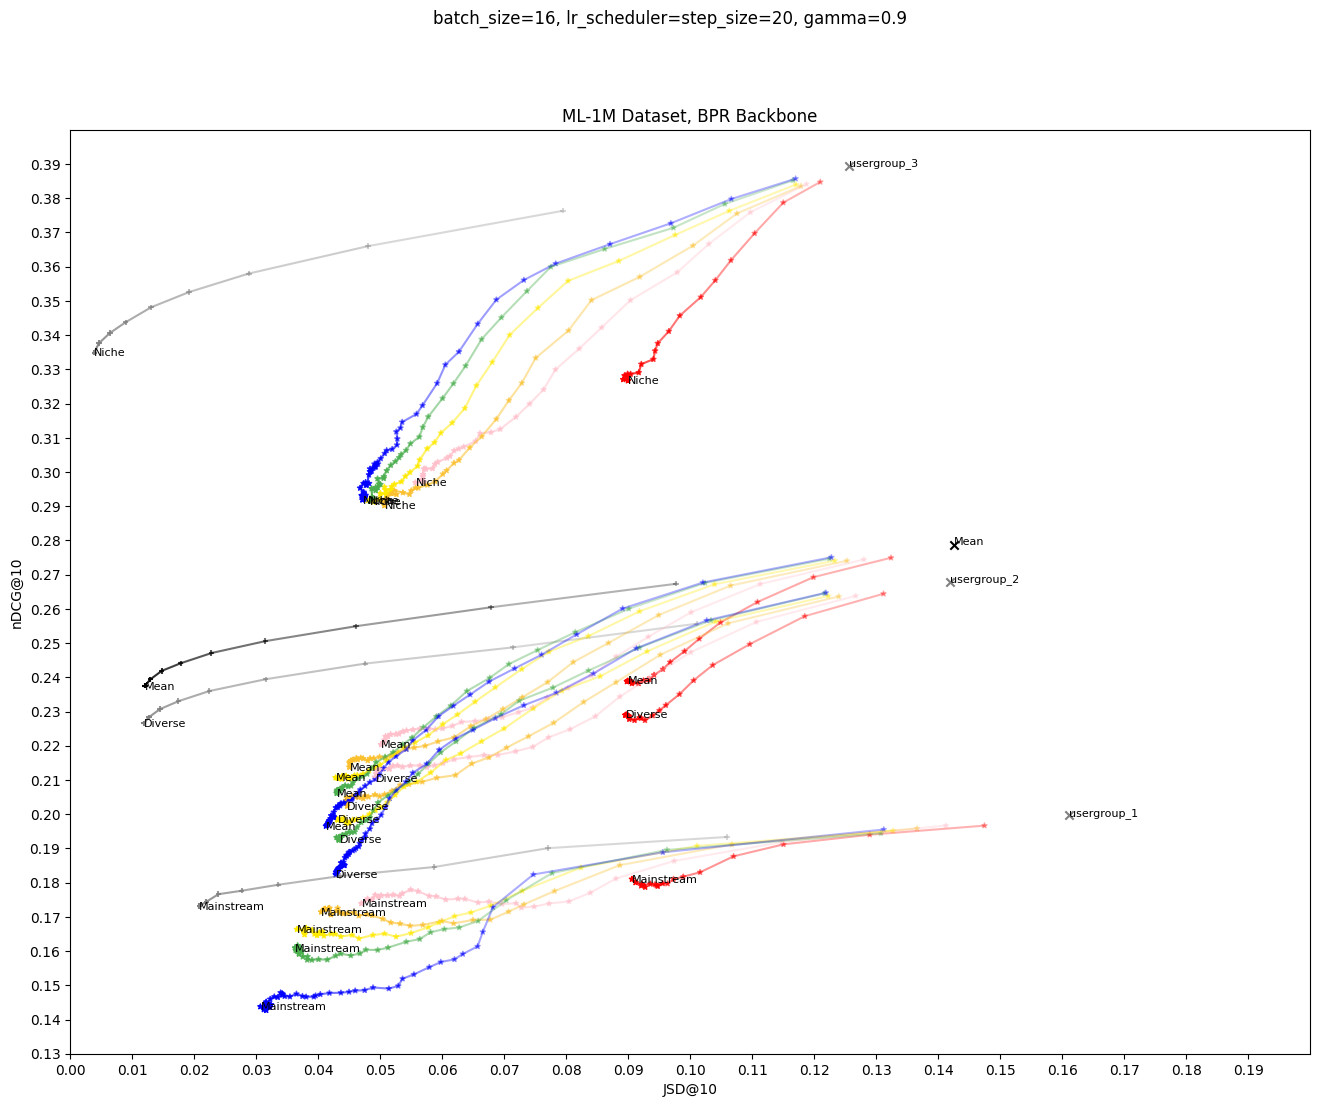

In [9]:
"""ML-1M Dataset"""
batch_size = 16
dataset = 'ML-1M Dataset, BPR Backbone'
lr_scheduler = 'step_size=20, gamma=0.9'

title = f'{dataset}'
suptitle = f'batch_size={batch_size}, lr_scheduler={lr_scheduler}'

USER_GROUPS = 3

BASELINE_EXPERIMENT = "metrics/ml-1m-bpr/c0.0__frozen_itememb__selection_relevance__k25__lr0.0001.json"

EXPERIMENTS_TO_SHOW = [
    'c0.0__unfrozen_itememb__selection_relevance__k100__lr0.0001',
    'c0.1__unfrozen_itememb__selection_relevance__k100__lr0.0001',
    'c0.25__unfrozen_itememb__selection_relevance__k100__lr0.0001',
    'c0.5__unfrozen_itememb__selection_relevance__k100__lr0.0001',
    'c0.75__unfrozen_itememb__selection_relevance__k100__lr0.0001',
    'c1.0__unfrozen_itememb__selection_relevance__k100__lr0.0001',
]

fig, ax = plt.subplots(figsize=(16, 12))
plt.title(title)
plt.suptitle(suptitle)

plt.ylabel('nDCG@10')
plt.xlabel('JSD@10')
plt.xlim(0, 0.20)
plt.ylim(0.13, 0.40)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.round(np.arange(start, end, 0.01), 2))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.round(np.arange(start, end, 0.01), 2))

with open(BASELINE_EXPERIMENT, 'r') as f:
    baseline = json.load(f)
    base_model = baseline["base_recommendations"]
    plt.scatter(base_model['jsd'], base_model['ndcg'], marker='x', color='black', label='Mean')
    ax.annotate('Mean', [base_model['jsd'], base_model['ndcg']], fontsize=8,)

    postprocessed = {
        'ndcg': [baseline['postprocessed'][l]['ndcg'] for l in baseline['postprocessed'].keys()],
        'jsd': [baseline['postprocessed'][l]['jsd'] for l in baseline['postprocessed'].keys()]
    }
    gradient_line(
        postprocessed['jsd'],
        postprocessed['ndcg'],
        ax,
        c='black',
        marker='+',
        lbl='Postprocessed (Mean)',
        final_model_label=f'Mean',
    )
    for group in range(1, USER_GROUPS + 1):
        group_key = f'usergroup_{group}'
        group_label = GROUP_LABELS[group]
        plt.scatter(base_model[f'jsd_{group_key}'], base_model[f'ndcg_{group_key}'], marker='x', color='gray', label=f'Backbone ({group_label})')
        ax.annotate(group_key, [base_model[f'jsd_{group_key}'], base_model[f'ndcg_{group_key}']], fontsize=8,)
        postprocessed_group = {
            'ndcg': [baseline['postprocessed'][l][f'ndcg_{group_key}'] for l in baseline['postprocessed'].keys()],
            'jsd': [baseline['postprocessed'][l][f'jsd_{group_key}'] for l in baseline['postprocessed'].keys()]
        }
        gradient_line(
            postprocessed_group['jsd'],
            postprocessed_group['ndcg'],
            ax,
            c='gray',
            marker='+',
            lbl=f'Postprocessed {group_key}',
            final_model_label=group_label,
        )

for experiment in EXPERIMENTS_TO_SHOW:
    with open(os.path.join('metrics', 'ml-1m-bpr', f'{experiment}.json')) as f:
        combined_mode_alpha, frozen_item_emb, candidate_selection_strategy, k_candidates, learning_rate = experiment.split('__')
        color = {
            'c0.0': 'red',
            'c0.1': 'pink',
            'c0.25': '#FBC02D',
            'c0.5': '#ffea00',
            'c0.75': '#4CAF50',
            'c1.0': 'blue'
        }[combined_mode_alpha]
        color_lr = {
            'lr0.001': 'red',
            'lr0.0005': 'green',
            'lr0.0001': 'blue',
            'lr0.00001': 'purple',
            'lr1e-05': 'purple',
            'lr1e-06': 'darkpurple'
        }[learning_rate]

        marker = {
            ('frozen_itememb', 'selection_relevance'): 'o',
            ('frozen_itememb', 'selection_random'): 'D',
            ('unfrozen_itememb', 'selection_relevance'): '*',
            ('unfrozen_itememb', 'selection_random'): 'X',
        }[frozen_item_emb, candidate_selection_strategy]

        data = json.load(f)
        experiment = f'{experiment}'

        finetuned_data = {
            'ndcg': [data['finetuned'][l]['ndcg'] for l in data['finetuned'].keys()],
            'jsd': [data['finetuned'][l]['jsd'] for l in data['finetuned'].keys()]
        }
        gradient_line(finetuned_data['jsd'], finetuned_data['ndcg'], ax,
                      c=color, marker=marker, final_model_label=f'Mean', filter=None)

        for group in range(1, USER_GROUPS + 1):
            group_key = f'usergroup_{group}'
            group_label = GROUP_LABELS[group]
            finetuned_data = {
                'ndcg': [data['finetuned'][l][f'ndcg_{group_key}'] for l in data['finetuned'].keys()],
                'jsd': [data['finetuned'][l][f'jsd_{group_key}'] for l in data['finetuned'].keys()]
            }
            gradient_line(
                finetuned_data['jsd'],
                finetuned_data['ndcg'],
                ax,
                c=color,
                marker=marker,
                lbl=f'{experiment} {group_label}',
                final_model_label=f'{group_label}',
            )

# plt.legend()
plt.savefig('visualization/img/calitune_usergroups_bpr_ml-1m.png', dpi=300, bbox_inches='tight')
plt.show()

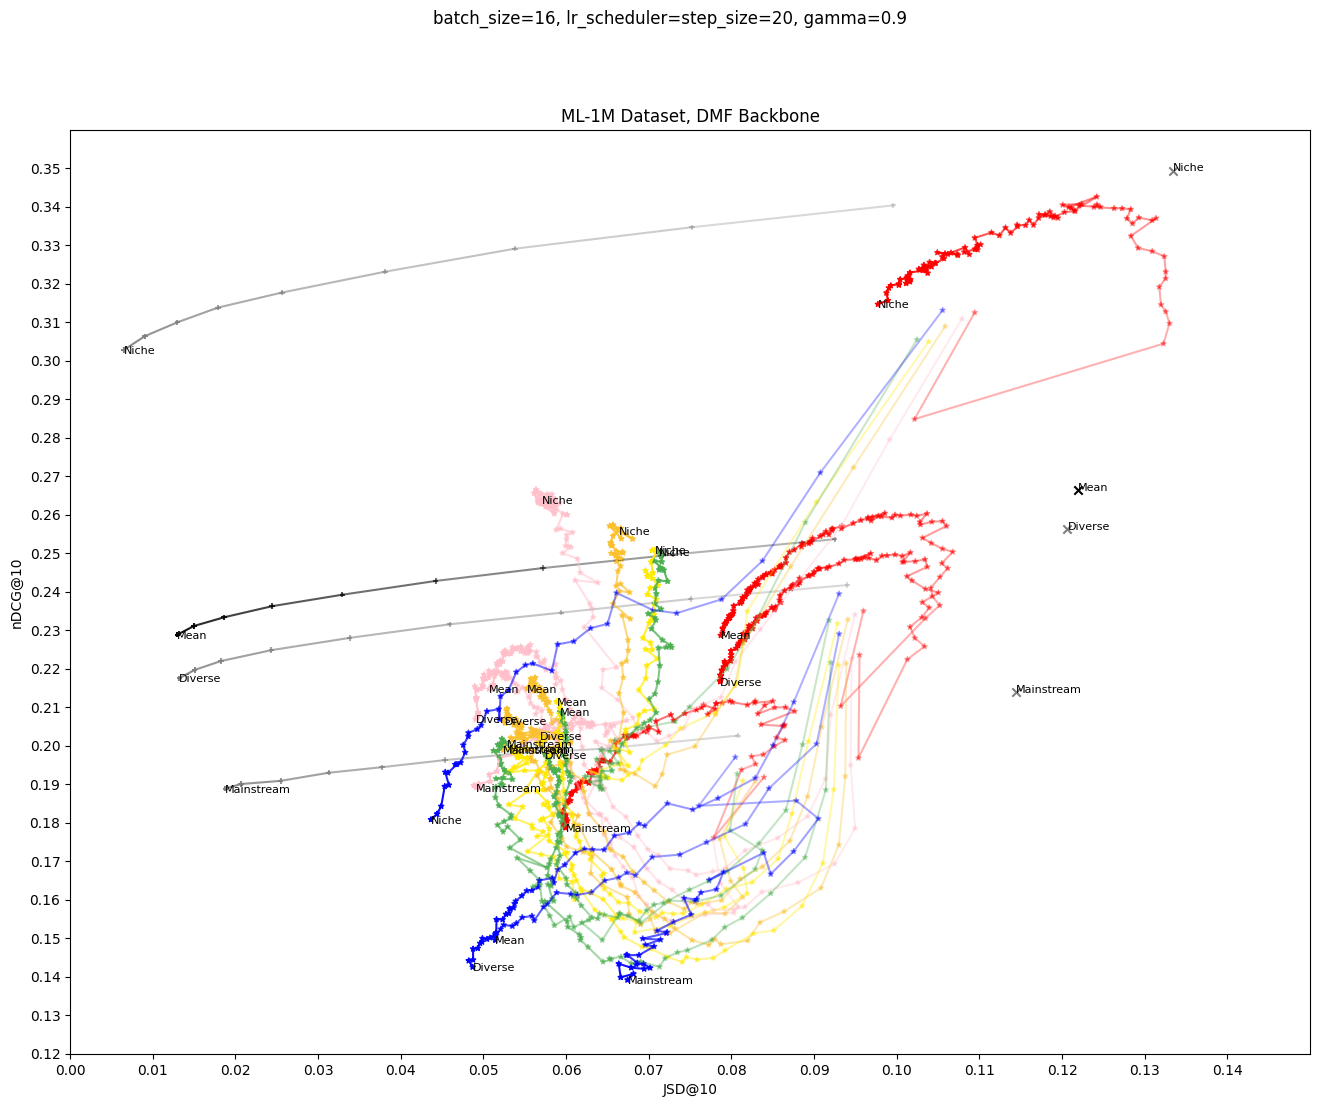

In [10]:
"""ML-1M Dataset + DMF"""
batch_size = 16
dataset = 'ML-1M Dataset, DMF Backbone'
lr_scheduler = 'step_size=20, gamma=0.9'

title = f'{dataset}'
suptitle = f'batch_size={batch_size}, lr_scheduler={lr_scheduler}'

USER_GROUPS = 3

BASELINE_EXPERIMENT = "metrics/ml-1m-dmf/c0.0__frozen_itememb__selection_relevance__k25__lr0.0005.json"

EXPERIMENTS_TO_SHOW = [
    'c0.0__unfrozen_itememb__selection_relevance__k200__lr1e-05',
    'c0.1__unfrozen_itememb__selection_relevance__k200__lr1e-05',
    'c0.25__unfrozen_itememb__selection_relevance__k200__lr1e-05',
    'c0.5__unfrozen_itememb__selection_relevance__k200__lr1e-05',
    'c0.75__unfrozen_itememb__selection_relevance__k200__lr1e-05',
    'c1.0__unfrozen_itememb__selection_relevance__k200__lr1e-05',
]

fig, ax = plt.subplots(figsize=(16, 12))
plt.title(title)
plt.suptitle(suptitle)

plt.ylabel('nDCG@10')
plt.xlabel('JSD@10')
plt.xlim(0, 0.15)
plt.ylim(0.12, 0.36)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.round(np.arange(start, end, 0.01), 2))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.round(np.arange(start, end, 0.01), 2))

with open(BASELINE_EXPERIMENT, 'r') as f:
    baseline = json.load(f)
    base_model = baseline["base_recommendations"]
    plt.scatter(base_model['jsd'], base_model['ndcg'], marker='x', color='black', label='Mean')
    ax.annotate('Mean', [base_model['jsd'], base_model['ndcg']], fontsize=8,)

    postprocessed = {
        'ndcg': [baseline['postprocessed'][l]['ndcg'] for l in baseline['postprocessed'].keys()],
        'jsd': [baseline['postprocessed'][l]['jsd'] for l in baseline['postprocessed'].keys()]
    }
    gradient_line(
        postprocessed['jsd'],
        postprocessed['ndcg'],
        ax,
        c='black',
        marker='+',
        lbl='Postprocessed (Mean)',
        final_model_label=f'Mean',
    )
    for group in range(1, USER_GROUPS + 1):
        group_key = f'usergroup_{group}'
        group_label = GROUP_LABELS[group]
        plt.scatter(base_model[f'jsd_{group_key}'], base_model[f'ndcg_{group_key}'], marker='x', color='gray', label=f'Backbone ({group_label})')
        ax.annotate(group_label, [base_model[f'jsd_{group_key}'], base_model[f'ndcg_{group_key}']], fontsize=8,)
        postprocessed_group = {
            'ndcg': [baseline['postprocessed'][l][f'ndcg_{group_key}'] for l in baseline['postprocessed'].keys()],
            'jsd': [baseline['postprocessed'][l][f'jsd_{group_key}'] for l in baseline['postprocessed'].keys()]
        }
        gradient_line(
            postprocessed_group['jsd'],
            postprocessed_group['ndcg'],
            ax,
            c='gray',
            marker='+',
            lbl=f'Postprocessed ({group_label})',
            final_model_label=group_label,
        )

for experiment in EXPERIMENTS_TO_SHOW:
    with open(os.path.join('metrics', 'ml-1m-dmf', f'{experiment}.json')) as f:
        combined_mode_alpha, frozen_item_emb, candidate_selection_strategy, k_candidates, learning_rate = experiment.split('__')
        color = {
            'c0.0': 'red',
            'c0.1': 'pink',
            'c0.25': '#FBC02D',
            'c0.5': '#ffea00',
            'c0.75': '#4CAF50',
            'c1.0': 'blue'
        }[combined_mode_alpha]
        color_lr = {
            'lr0.001': 'red',
            'lr0.0005': 'green',
            'lr0.0001': 'blue',
            'lr0.00001': 'purple',
            'lr1e-05': 'purple',
            'lr1e-06': 'darkpurple'
        }[learning_rate]

        marker = {
            ('frozen_itememb', 'selection_relevance'): 'o',
            ('frozen_itememb', 'selection_random'): 'D',
            ('unfrozen_itememb', 'selection_relevance'): '*',
            ('unfrozen_itememb', 'selection_random'): 'X',
        }[frozen_item_emb, candidate_selection_strategy]

        data = json.load(f)
        experiment = f'{experiment}'

        finetuned_data = {
            'ndcg': [data['finetuned'][l]['ndcg'] for l in data['finetuned'].keys()],
            'jsd': [data['finetuned'][l]['jsd'] for l in data['finetuned'].keys()]
        }
        gradient_line(finetuned_data['jsd'], finetuned_data['ndcg'], ax,
                      c=color, marker=marker, final_model_label=f'Mean', filter=None)

        for group in range(1, USER_GROUPS + 1):
            group_key = f'usergroup_{group}'
            group_label = GROUP_LABELS[group]
            finetuned_data = {
                'ndcg': [data['finetuned'][l][f'ndcg_{group_key}'] for l in data['finetuned'].keys()],
                'jsd': [data['finetuned'][l][f'jsd_{group_key}'] for l in data['finetuned'].keys()]
            }

            gradient_line(
                finetuned_data['jsd'],
                finetuned_data['ndcg'],
                ax,
                c=color,
                marker=marker,
                lbl=f'{experiment} {group_key}',
                final_model_label=group_label,
            )

# plt.legend()
plt.savefig('visualization/img/calitune_usergroups_dmf_ml-1m.png', dpi=300, bbox_inches='tight')
plt.show()

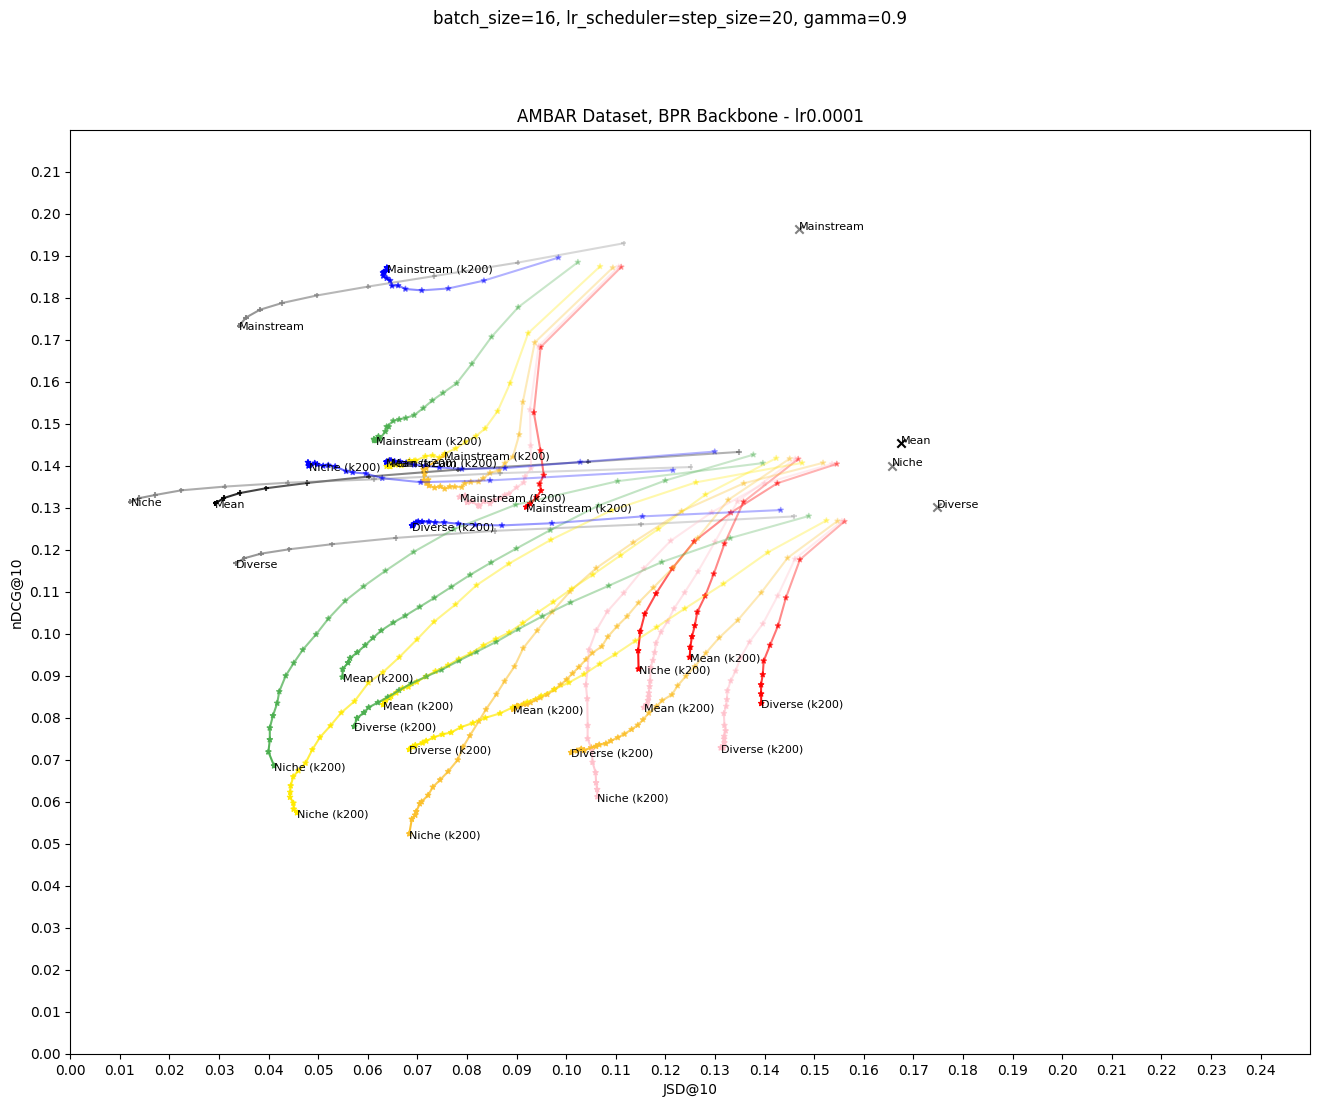

In [12]:
"""AMBAR Dataset + BPR"""
batch_size = 16
dataset = 'AMBAR Dataset, BPR Backbone - lr0.0001'
lr_scheduler = 'step_size=20, gamma=0.9'

title = f'{dataset}'
suptitle = f'batch_size={batch_size}, lr_scheduler={lr_scheduler}'

USER_GROUPS = 3

BASELINE_EXPERIMENT = "metrics/ambar-bpr/c0.0__frozen_itememb__selection_relevance__k25__lr0.0005.json"

EXPERIMENTS_TO_SHOW = [
    # 'c0.0__frozen_itememb__selection_relevance__k25__lr0.0001',
    # 'c0.0__frozen_itememb__selection_relevance__k50__lr0.0001',
    # 'c0.0__frozen_itememb__selection_relevance__k100__lr0.0001',
    # 'c0.0__frozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.0__frozen_itememb__selection_relevance__k400__lr0.0001',
    # 'c0.0__frozen_itememb__selection_relevance__k1600__lr0.0005',

    'c0.0__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    'c0.1__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    'c0.25__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    'c0.5__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    'c0.75__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    'c1.0__unfrozen_itememb__selection_relevance__k200__lr0.0001',

    # 'c0.1__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.25__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.5__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.75__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c1.0__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.0__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.1__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.25__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.5__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.75__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c1.0__unfrozen_itememb__selection_relevance__k200__lr0.0001',
]

fig, ax = plt.subplots(figsize=(16, 12))
plt.title(title)
plt.suptitle(suptitle)

plt.ylabel('nDCG@10')
plt.xlabel('JSD@10')
plt.xlim(0, 0.25)
plt.ylim(0, 0.22)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.round(np.arange(start, end, 0.01), 2))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.round(np.arange(start, end, 0.01), 2))

with open(BASELINE_EXPERIMENT, 'r') as f:
    baseline = json.load(f)
    base_model = baseline["base_recommendations"]
    plt.scatter(base_model['jsd'], base_model['ndcg'], marker='x', color='black', label='Mean')
    ax.annotate('Mean', [base_model['jsd'], base_model['ndcg']], fontsize=8,)

    postprocessed = {
        'ndcg': [baseline['postprocessed'][l]['ndcg'] for l in baseline['postprocessed'].keys()],
        'jsd': [baseline['postprocessed'][l]['jsd'] for l in baseline['postprocessed'].keys()]
    }
    gradient_line(
        postprocessed['jsd'],
        postprocessed['ndcg'],
        ax,
        c='black',
        marker='+',
        lbl='Postprocessed (Mean)',
        final_model_label=f'Mean',
    )
    for group in range(1, USER_GROUPS + 1):
        group_key = f'usergroup_{group}'
        group_label = GROUP_LABELS[group]
        plt.scatter(base_model[f'jsd_{group_key}'], base_model[f'ndcg_{group_key}'], marker='x', color='gray', label=f'Backbone ({group_label})')
        ax.annotate(group_label, [base_model[f'jsd_{group_key}'], base_model[f'ndcg_{group_key}']], fontsize=8,)
        postprocessed_group = {
            'ndcg': [baseline['postprocessed'][l][f'ndcg_{group_key}'] for l in baseline['postprocessed'].keys()],
            'jsd': [baseline['postprocessed'][l][f'jsd_{group_key}'] for l in baseline['postprocessed'].keys()]
        }
        gradient_line(
            postprocessed_group['jsd'],
            postprocessed_group['ndcg'],
            ax,
            c='gray',
            marker='+',
            lbl=f'Postprocessed {group_key}',
            final_model_label=group_label,
        )

for experiment in EXPERIMENTS_TO_SHOW:
    with open(os.path.join('metrics', 'ambar-bpr', f'{experiment}.json')) as f:
        combined_mode_alpha, frozen_item_emb, candidate_selection_strategy, k_candidates, learning_rate = experiment.split('__')
        color = {
            'c0.0': 'red',
            'c0.1': 'pink',
            'c0.25': '#FBC02D',
            'c0.5': '#ffea00',
            'c0.75': '#4CAF50',
            'c1.0': 'blue'
        }[combined_mode_alpha]
        color_lr = {
            'lr0.001': 'red',
            'lr0.0005': 'green',
            'lr0.0001': 'blue',
            'lr0.00001': 'purple',
            'lr1e-05': 'purple',
            'lr1e-06': 'darkpurple'
        }[learning_rate]

        marker = {
            ('frozen_itememb', 'selection_relevance'): 'o',
            ('frozen_itememb', 'selection_random'): 'D',
            ('unfrozen_itememb', 'selection_relevance'): '*',
            ('unfrozen_itememb', 'selection_random'): 'X',
        }[frozen_item_emb, candidate_selection_strategy]

        data = json.load(f)
        experiment = f'{experiment}'

        finetuned_data = {
            'ndcg': [data['finetuned'][l]['ndcg'] for l in data['finetuned'].keys()],
            'jsd': [data['finetuned'][l]['jsd'] for l in data['finetuned'].keys()]
        }
        gradient_line(finetuned_data['jsd'], finetuned_data['ndcg'], ax,
                      c=color, marker=marker, final_model_label=f'Mean ({k_candidates})', filter=None)

        for group in range(1, USER_GROUPS + 1):
            group_key = f'usergroup_{group}'
            group_label = GROUP_LABELS[group]
            finetuned_data = {
                'ndcg': [data['finetuned'][l][f'ndcg_{group_key}'] for l in data['finetuned'].keys()],
                'jsd': [data['finetuned'][l][f'jsd_{group_key}'] for l in data['finetuned'].keys()]
            }
            gradient_line(
                finetuned_data['jsd'],
                finetuned_data['ndcg'],
                ax,
                c=color,
                marker=marker,
                lbl=f'{experiment} {group_key}',
                final_model_label=f'{group_label} ({k_candidates})',
            )

plt.savefig('visualization/img/calitune_usergroups_bpr_ambar.png', dpi=300, bbox_inches='tight')
# plt.legend()
plt.show()

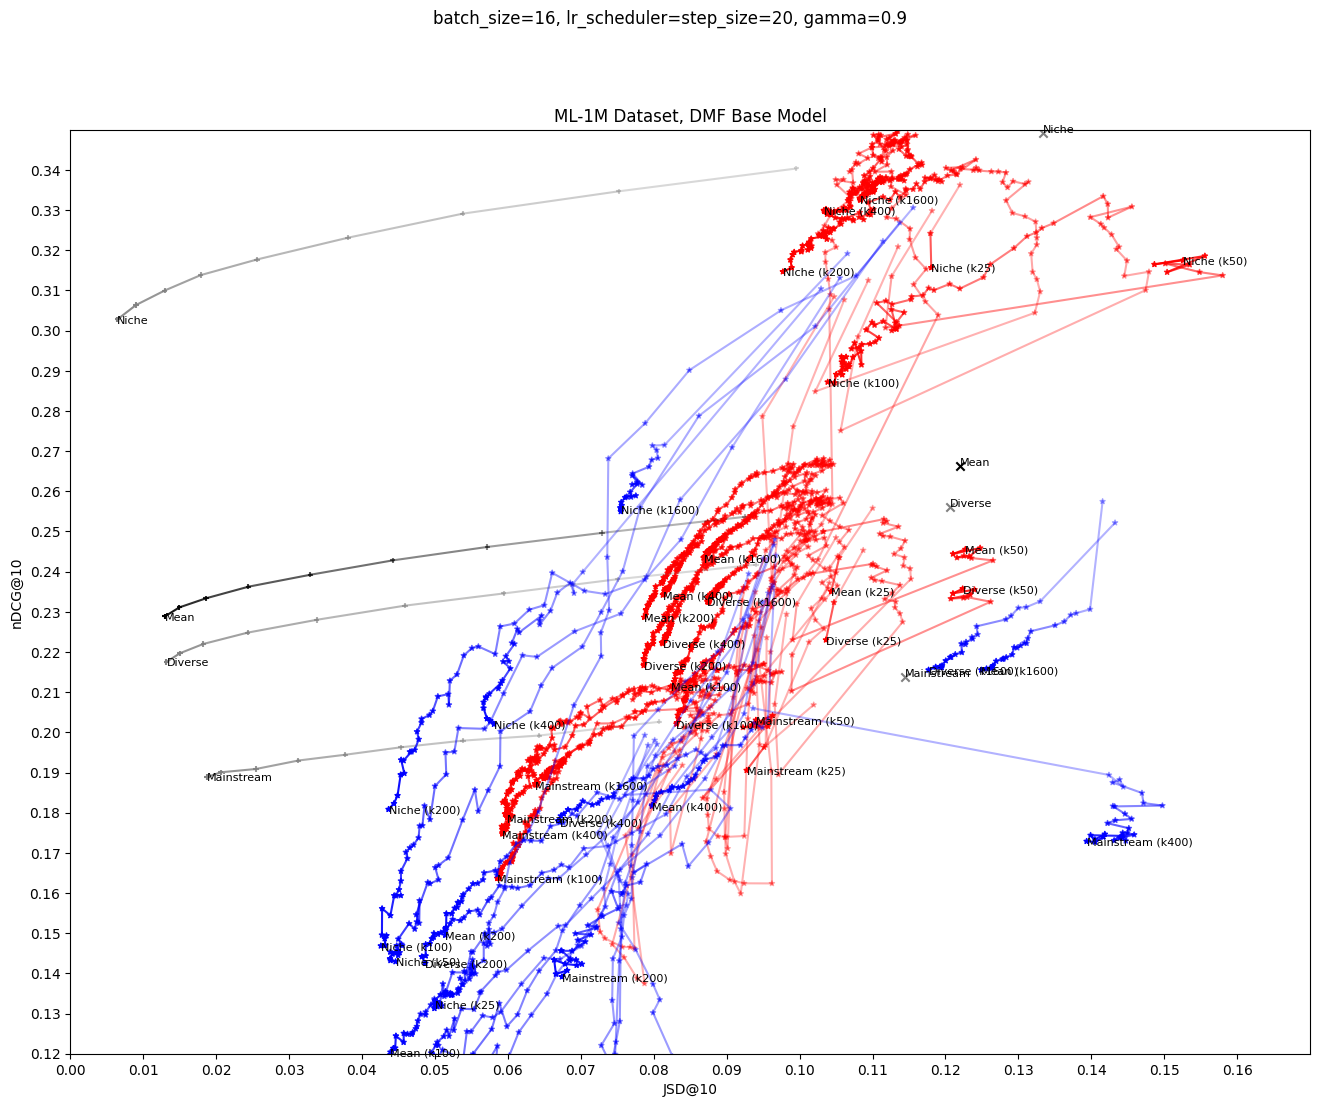

In [6]:
"""Comparing K-Candidates"""
batch_size = 16
dataset = 'ML-1M Dataset, DMF Backbone'
lr_scheduler = 'step_size=20, gamma=0.9'

title = f'{dataset}'
suptitle = f'batch_size={batch_size}, lr_scheduler={lr_scheduler}'

USER_GROUPS = 3

BASELINE_EXPERIMENT = "metrics/ml-1m-dmf/c0.0__frozen_itememb__selection_relevance__k25__lr0.0005.json"

EXPERIMENTS_TO_SHOW = [
    'c0.0__unfrozen_itememb__selection_relevance__k25__lr1e-05',
    'c0.0__unfrozen_itememb__selection_relevance__k50__lr1e-05',
    'c0.0__unfrozen_itememb__selection_relevance__k100__lr1e-05',
    'c0.0__unfrozen_itememb__selection_relevance__k200__lr1e-05',
    'c0.0__unfrozen_itememb__selection_relevance__k400__lr1e-05',
    'c0.0__unfrozen_itememb__selection_relevance__k1600__lr1e-05',
    'c1.0__unfrozen_itememb__selection_relevance__k25__lr1e-05',
    'c1.0__unfrozen_itememb__selection_relevance__k50__lr1e-05',
    'c1.0__unfrozen_itememb__selection_relevance__k100__lr1e-05',
    'c1.0__unfrozen_itememb__selection_relevance__k200__lr1e-05',
    'c1.0__unfrozen_itememb__selection_relevance__k400__lr1e-05',
    'c1.0__unfrozen_itememb__selection_relevance__k1600__lr1e-05',
    # 'c0.1__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.25__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.5__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.75__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c1.0__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.0__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.1__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.25__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.5__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c0.75__unfrozen_itememb__selection_relevance__k200__lr0.0001',
    # 'c1.0__unfrozen_itememb__selection_relevance__k200__lr0.0001',
]

fig, ax = plt.subplots(figsize=(16, 12))
plt.title(title)
plt.suptitle(suptitle)

plt.ylabel('nDCG@10')
plt.xlabel('JSD@10')
plt.xlim(0, 0.17)
plt.ylim(0.12, 0.35)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.round(np.arange(start, end, 0.01), 2))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.round(np.arange(start, end, 0.01), 2))

with open(BASELINE_EXPERIMENT, 'r') as f:
    baseline = json.load(f)
    base_model = baseline["base_recommendations"]
    plt.scatter(base_model['jsd'], base_model['ndcg'], marker='x', color='black', label='Mean')
    ax.annotate('Mean', [base_model['jsd'], base_model['ndcg']], fontsize=8,)

    postprocessed = {
        'ndcg': [baseline['postprocessed'][l]['ndcg'] for l in baseline['postprocessed'].keys()],
        'jsd': [baseline['postprocessed'][l]['jsd'] for l in baseline['postprocessed'].keys()]
    }
    gradient_line(
        postprocessed['jsd'],
        postprocessed['ndcg'],
        ax,
        c='black',
        marker='+',
        lbl='Postprocessed (Mean)',
        final_model_label=f'Mean',
    )
    for group in range(1, USER_GROUPS + 1):
        group_key = f'usergroup_{group}'
        group_label = GROUP_LABELS[group]
        plt.scatter(base_model[f'jsd_{group_key}'], base_model[f'ndcg_{group_key}'], marker='x', color='gray', label=f'Backbone ({group_label})')
        ax.annotate(group_label, [base_model[f'jsd_{group_key}'], base_model[f'ndcg_{group_key}']], fontsize=8,)
        postprocessed_group = {
            'ndcg': [baseline['postprocessed'][l][f'ndcg_{group_key}'] for l in baseline['postprocessed'].keys()],
            'jsd': [baseline['postprocessed'][l][f'jsd_{group_key}'] for l in baseline['postprocessed'].keys()]
        }
        gradient_line(
            postprocessed_group['jsd'],
            postprocessed_group['ndcg'],
            ax,
            c='gray',
            marker='+',
            lbl=f'Postprocessed {group_key}',
            final_model_label=group_label,
        )

for experiment in EXPERIMENTS_TO_SHOW:
    with open(os.path.join('metrics', 'ml-1m-dmf', f'{experiment}.json')) as f:
        combined_mode_alpha, frozen_item_emb, candidate_selection_strategy, k_candidates, learning_rate = experiment.split('__')
        color = {
            'c0.0': 'red',
            'c0.1': 'pink',
            'c0.25': '#FBC02D',
            'c0.5': '#ffea00',
            'c0.75': '#4CAF50',
            'c1.0': 'blue'
        }[combined_mode_alpha]
        color_lr = {
            'lr0.001': 'red',
            'lr0.0005': 'green',
            'lr0.0001': 'blue',
            'lr0.00001': 'purple',
            'lr1e-05': 'purple',
            'lr1e-06': 'darkpurple'
        }[learning_rate]

        marker = {
            ('frozen_itememb', 'selection_relevance'): 'o',
            ('frozen_itememb', 'selection_random'): 'D',
            ('unfrozen_itememb', 'selection_relevance'): '*',
            ('unfrozen_itememb', 'selection_random'): 'X',
        }[frozen_item_emb, candidate_selection_strategy]

        data = json.load(f)
        experiment = f'{experiment}'

        finetuned_data = {
            'ndcg': [data['finetuned'][l]['ndcg'] for l in data['finetuned'].keys()],
            'jsd': [data['finetuned'][l]['jsd'] for l in data['finetuned'].keys()]
        }
        gradient_line(finetuned_data['jsd'], finetuned_data['ndcg'], ax,
                      c=color, marker=marker, final_model_label=f'Mean ({k_candidates})', filter=None)

        for group in range(1, USER_GROUPS + 1):
            group_key = f'usergroup_{group}'
            group_label = GROUP_LABELS[group]
            finetuned_data = {
                'ndcg': [data['finetuned'][l][f'ndcg_{group_key}'] for l in data['finetuned'].keys()],
                'jsd': [data['finetuned'][l][f'jsd_{group_key}'] for l in data['finetuned'].keys()]
            }
            gradient_line(
                finetuned_data['jsd'],
                finetuned_data['ndcg'],
                ax,
                c=color,
                marker=marker,
                lbl=f'{experiment} {group_key}',
                final_model_label=f'{group_label} ({k_candidates})',
            )

# plt.legend()
plt.show()